In [1]:
import os
import glob

import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import gc
from tqdm import tqdm



import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply,Flatten, ReLU, Dense, AveragePooling2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model

In [2]:
import tensorflow_addons as tfa

In [3]:
from tensorflow import ones_like

In [4]:
machine = "gpu"

if machine == "gpu":
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    strategy = tf.distribute.get_strategy()

2022-11-28 23:24:56.411008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 23:24:56.497037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:24:56.630958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:24:56.632398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Num GPUs Available:  1


2022-11-28 23:24:59.515610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:24:59.516900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:24:59.518036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
BATCH_SIZE = 32
LEARNING_RATE = 3e-5

In [6]:
np.random.seed(80085)
tf.random.set_seed(80085)

In [7]:
DIR = "../input/pulmonary-dataset/kaggle/Pulmonary_dataset/RSNA"

In [8]:
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=5,
      shear_range=0.1,
      zoom_range=0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    validation_split=0.4)

In [9]:
train_generator = datagen.flow_from_directory(
        DIR,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training')

Found 173772 images belonging to 2 classes.


In [10]:
valid_generator = datagen.flow_from_directory(
        DIR,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='binary', 
        subset='validation')

Found 115848 images belonging to 2 classes.


In [11]:
#from tensorflow.keras.applications import DenseNet121

#conv_base = DenseNet121(weights=None, include_top=False, input_shape=(256,256,3))

In [12]:
#model = Sequential()
#model.add(conv_base)
#model.add(GlobalMaxPooling2D())
#model.add(Dense(units = 32))
#model.add(BatchNormalization())
#model.add(ReLU())
#model.add(Dropout(0.2))

#model.add(Dense(1, activation="sigmoid"))
#conv_base.trainable = True

In [13]:
#from tensorflow.keras.applications import ResNet50V2

#model = ResNet50V2(weights=None, include_top=True, input_shape=(256, 256, 3),classes=1,classifier_activation="sigmoid")

In [14]:
from tensorflow.keras.applications import EfficientNetB2

model = EfficientNetB2(weights=None, include_top=True, input_shape=(256, 256, 3),classes=1, classifier_activation="sigmoid")

2022-11-28 23:27:59.641521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:27:59.642879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:27:59.643909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:27:59.645489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 23:27:59.646734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [15]:
#model.summary()

In [16]:
!mkdir /kaggle/models

In [17]:
loss = tf.keras.losses.BinaryCrossentropy() #tfa.losses.SigmoidFocalCrossEntropy()
model.compile(loss=loss, 
              optimizer=tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay = 0.01), 
              metrics=['binary_accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 3, verbose=1, factor=0.1, min_lr=1e-7)

filepath = "/kaggle/models/saved-model-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=False, save_freq='epoch')


In [18]:
!nvidia-smi

Mon Nov 28 23:28:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |    439MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=valid_generator,
      callbacks=[checkpoint,learning_rate_reduction],
    class_weight = {0: 3/5, 1: 2/5},
      verbose=1)

2022-11-28 23:28:05.069856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-11-28 23:28:19.624653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5431/5431 [==============================] - 6385s 1s/step - loss: 0.3254 - binary_accuracy: 0.6665 - val_loss: 0.6929 - val_binary_accuracy: 0.6667

Epoch 00001: saving model to /kaggle/models/saved-model-01-0.67.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
5431/5431 [==============================] - 5872s 1s/step - loss: 0.3234 - binary_accuracy: 0.6667 - val_loss: 0.6927 - val_binary_accuracy: 0.6667

Epoch 00002: saving model to /kaggle/models/saved-model-02-0.67.hdf5
Epoch 3/5
5431/5431 [==============================] - 5768s 1s/step - loss: 0.3234 - binary_accuracy: 0.6667 - val_loss: 0.6923 - val_binary_accuracy: 0.6667

Epoch 00003: saving model to /kaggle/models/saved-model-03-0.67.hdf5
Epoch 4/5
5431/5431 [==============================] - 5726s 1s/step - loss: 0.3234 - binary_accuracy: 0.6667 - val_loss: 0.6927 - val_binary_accuracy: 0.6667

Epoch 00004: saving model to /kaggle/models/saved-model-04-0.67.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
Epoch 5/5
5431/5431 [==============================] - 5703s 1s/step - loss: 0.3235 - binary_accuracy: 0.6667 - val_loss: 0.6931 - val_binary_accuracy: 0.6667

Epoch 00005: saving model to /kaggle/models/saved-model-05-0.67.hdf5


In [20]:
def plot_history():
    plt.plot(history.history['binary_accuracy'], label='The score of correct predictions on the training set')
    plt.plot(history.history['val_binary_accuracy'], label='The score of correct predictions on the val set')
    plt.xlabel('Epoch')
    plt.ylabel('Score correct answers')
    plt.legend()
    plt.show()

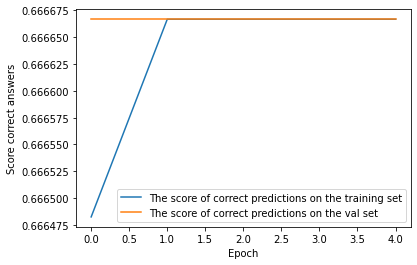

In [21]:
plot_history()

In [22]:
best_acc = 0
best_model = ""
for i in os.listdir("/kaggle/models"):
    model.load_weights("/kaggle/models/"+i)
    loss, acc = model.evaluate_generator(valid_generator, steps=3, verbose=0)
    if acc > best_acc:
        best_model = i
        best_acc = acc

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [23]:
model.load_weights("/kaggle/models/"+best_model)
loss, acc = model.evaluate_generator(valid_generator, steps=3, verbose=0)
acc = acc *100
print(f"accuracy is: {acc:.2f}%")
print("best model is " + best_model)

accuracy is: 71.88%
best model is saved-model-02-0.67.hdf5


In [24]:
from IPython.display import FileLink
FileLink(r"/kaggle/models/"+best_model)

/kaggle/models/saved-model-02-0.67.hdf5

In [25]:
!mkdir /kaggle/working/models

In [26]:
shutil.move("/kaggle/models/", "/kaggle/working/models/")
shutil.make_archive("/kaggle/working/models.zip", 'zip', "/kaggle/working/models/")


FileLink(r"/kaggle/working/models.zip.zip")

/kaggle/working/models.zip.zip